In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

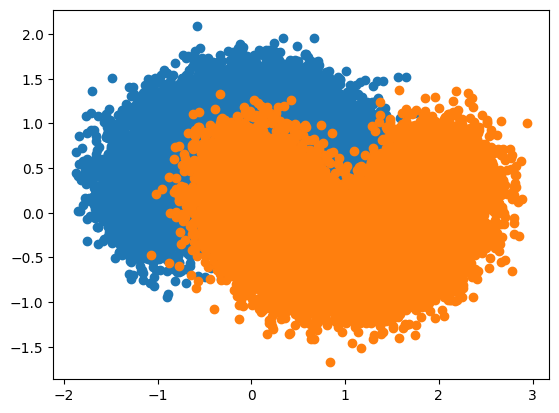

In [3]:
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
plt.scatter(x[y == 0, 0], x[y == 0, 1])
plt.scatter(x[y == 1, 0], x[y == 1, 1])
plt.show()

In [4]:
x

array([[ 0.71820567, -0.21809028],
       [ 0.11096372,  1.10964541],
       [ 0.61562814, -0.06539887],
       ...,
       [ 1.58004352, -0.3637176 ],
       [ 0.90929791, -0.09962261],
       [-0.97512015,  0.87195198]])

In [5]:
y

array([1, 0, 0, ..., 1, 0, 0])

In [6]:
#默认分割比例是75%和25%
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [7]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85344

In [16]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87568

In [11]:
#训练好模型，测试集做预测
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)

In [12]:
#bagging
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
y_predict[:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [13]:
y_test[:10]

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [15]:
from sklearn.metrics import accuracy_score

#accuracy_score计算准确率的
accuracy_score(y_test, y_predict)

0.90448

# 集成学习VotingClassifier

In [17]:
from sklearn.ensemble import VotingClassifier

#hard模式就是少数服从多数
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())], voting='hard')

In [18]:
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.9048

# 更合理的投票，应该有权值

In [19]:
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  #支持向量机中需要加入probability
    ('dt_clf', DecisionTreeClassifier())], voting='soft')
voting_clf2.fit(x_train, y_train)
voting_clf2.score(x_test, y_test)


0.90424

# 使用bagging

In [20]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=1000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.91264

# oob设计

In [21]:
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
bagging_clf2.oob_score_  #拿没有取到的数据集作为测试集

0.91184

# njobs

In [22]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

In [26]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 1.58 s
Wall time: 2.95 s


0.90912

In [25]:
%%time
#多核使用的时间更小
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=100,
                                bootstrap=True, n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 188 ms
Wall time: 8.35 s


0.90824

# bootstrap_features  对特征进行采样

In [27]:
#因为我们就两个特征，所以max_features设置为1,得到的分值较低是因为我们特征较少，采用随机特征不合适
#这个是只对特征进行采样
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500, max_samples=500, oob_score=True,
                                         bootstrap=True, n_jobs=-1,
                                         max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(x, y)
random_subspaces_clf.oob_score_

0.8866

In [28]:
# 下面是对特征采样
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                                       n_estimators=500, max_samples=10000, oob_score=True,
                                       bootstrap=True, n_jobs=-1,
                                       max_features=1, bootstrap_features=True)
random_patches_clf.fit(x, y)
random_patches_clf.oob_score_
#就是随机森林

0.87004

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
%%time
rc_clf = RandomForestClassifier(n_estimators=500, random_state=666,
                                oob_score=True, n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 1min 24s
Wall time: 11 s


0.90322

In [31]:
%%time
rc_clf = RandomForestClassifier(max_samples=37500, n_jobs=-1)
rc_clf.fit(x_train, y_train)
rc_clf.score(x_test, y_test)

CPU times: total: 11.1 s
Wall time: 1.43 s


0.90368

In [43]:
%%time
#max_leaf_nodes 最大的叶子结点数
rc_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 random_state=666,
                                 oob_score=True, n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 32 s
Wall time: 6 s


0.90962

# Extra-Trees

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90668

# Boosting

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [40]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)


C:\Users\30663\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: total: 234 ms
Wall time: 322 ms


0.87624

In [41]:
#它默认用的也是决策树，增加了基分类器的数目后，准确率提升
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=500)
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

0.91144